# Fraud detection

The purpose of this assignment is to detect fraudulent transactions from a data set of bank transactions

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load traing data
data = pd.read_csv('BankTrain.csv')

In [3]:
# Start exploring the dataset
print(data.columns)

Index(['Transaction id', 'Client id', 'Transaction value', 'Merchant id',
       ' Date', 'Time', 'Class'],
      dtype='object')


In [4]:
#set transaction id as index 
data.set_index(['Transaction id'],inplace = True)

Histograms of the data were then produced to provide a basic understanding of how each column was distributed,

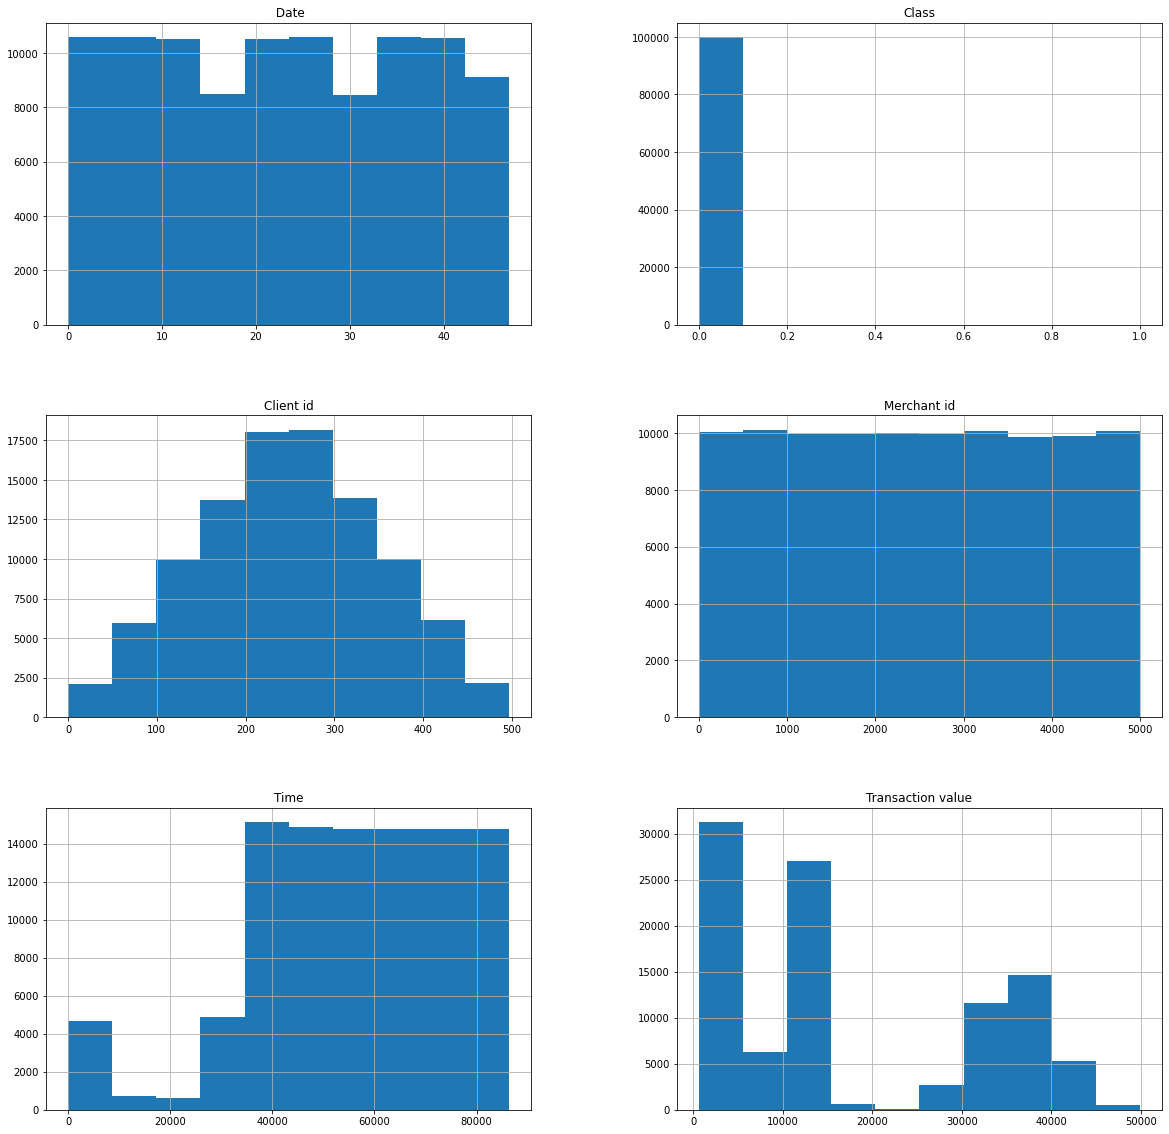

In [5]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

Transaction values are the most important feature set of the data so we will use seaborns to construct a distribution plot of their distribution. Interestingly the transaction values tended to fall into 1 of 3 gaussian distributions which is displayed below. This begs the question do outliers from these distributions correspond to suspicious activity?

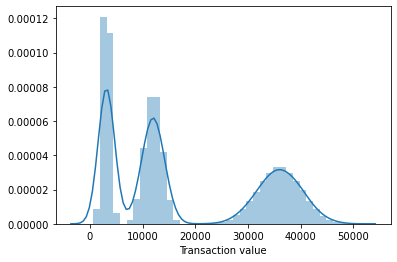

In [6]:
#build dist plot for transaction values
sns.distplot(data['Transaction value'])

In [7]:
#calculate number of frauds

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

#find all clients with fraud
transactionsIdfFraud = data['Client id'][data['Class'] == 1].values


0.00010001000100010001
Fraud Cases: 10
Valid Transactions: 99990


Since the relative number of fraudulent transactions is so small 0.01 percent of the data set it is useful visualise all clients who performed fraudulent transactions and observe distinct common patterns

In [8]:
#build dataframe of all transactions from clients with fraud
fraudTrans = pd.DataFrame()
for i in range(len(transactionsIdfFraud)):
    iData = data[data['Client id'] == transactionsIdfFraud[i]]
    fraudTrans = fraudTrans.append(iData)
    
print(fraudTrans)
    


                Client id  Transaction value  Merchant id   Date   Time  Class
Transaction id                                                                
6213                  496               3726          311      2  83429      0
33264                 496              21794         3701     15  71159      1
93320                 496               1474         3866     44  37237      0
174                   357               3639         2045      0  33104      0
695                   357               3476          828      0  47333      0
...                   ...                ...          ...    ...    ...    ...
95518                  52              41722         1892     45  39728      0
96675                  52              34133         4077     45  71811      0
97637                  52              39458         3490     46  40286      0
98274                  52              29050         4962     46  57667      0
99297                  52              35145        

In [9]:
#find allunique clients with fraud
fraudClients = fraudTrans['Client id'].unique()

Now we will plot these transactions highlighting the fraudulent transaction by making them red

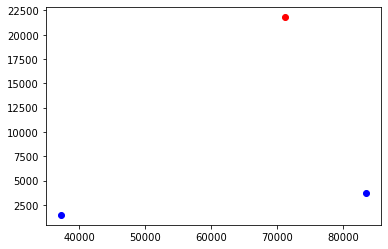

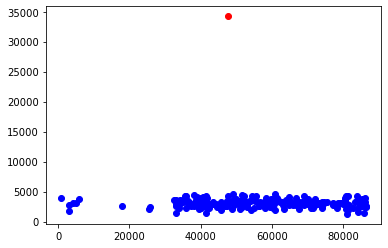

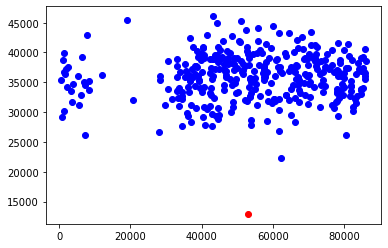

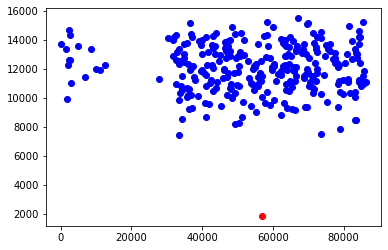

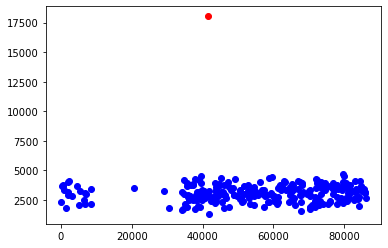

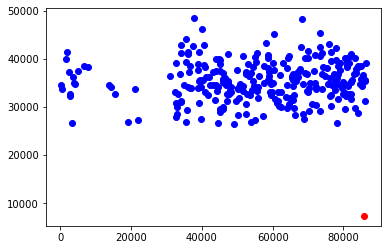

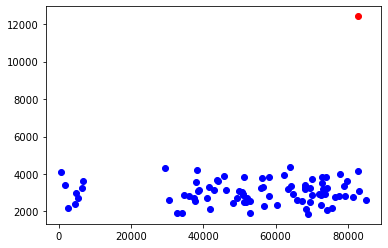

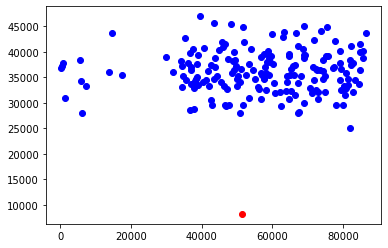

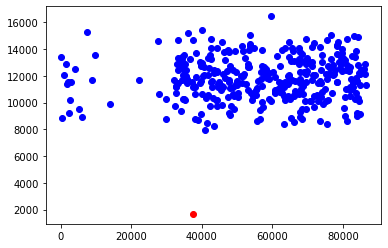

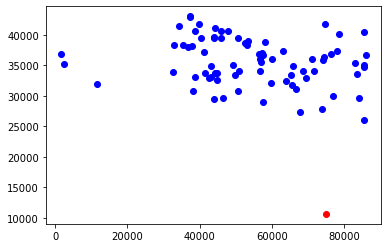

In [10]:
#chart fraudulent clients make fraud transaction red
col = []
for i in range(len(fraudTrans)):
    if fraudTrans.iloc[i]['Class'] == 1:
        col.append('r')
    else:
        col.append('b')

i = 0
for client in fraudClients:

    fig = plt.figure()
    plt.subplot(1,1,1)
    df = fraudTrans[fraudTrans['Client id']==client]
    for iplot in range(len(df)):
        plt.scatter(df.iloc[iplot]['Time'],df.iloc[iplot]['Transaction value'],c = col[i])
        #print(col[i])
        plt.show
        plotFileName = 'plot'+str(i)+'.png'
        i =i+1
    fig.savefig(plotFileName)

From viewing the results, it's obvious that fraudulent transaction values are significantly distant from the rest of the values. We can try to construct a statistic which could identify these outliers. To determine outliers from the distribution of the client’s transactions we use the median the modified z score for each transaction was calculated

$$
M_i= \frac{0.6745(x_i-x^\sim)}{MAD}
$$

Where

x_i= the transaction value

𝑥̃=median value of the client’s transactions

MAD = the median of the absolute of 𝑥𝑖−𝑥̃

To test if this was a suitable statistic it calculated on the training data and the transactions

In [11]:
# calculate modified z scores

#calculate medians for each client
clientMedian = fraudTrans.groupby(['Client id'])['Transaction value'].median()

clientMedianDict = fraudTrans.groupby(['Client id'])['Transaction value'].median().to_dict()

#calculate statistic

#calcukate deviation from median for each transaction
medianDevList = []
for i in range(len(fraudTrans)):
    #calculate the MAD
    medianDev = abs(fraudTrans.iloc[i]['Transaction value']-clientMedianDict[fraudTrans.iloc[i]['Client id']])
    medianDevList.append(medianDev)
fraudTrans['Median Dev'] = medianDevList   



In [12]:
print(fraudTrans)

                Client id  Transaction value  Merchant id   Date   Time  \
Transaction id                                                            
6213                  496               3726          311      2  83429   
33264                 496              21794         3701     15  71159   
93320                 496               1474         3866     44  37237   
174                   357               3639         2045      0  33104   
695                   357               3476          828      0  47333   
...                   ...                ...          ...    ...    ...   
95518                  52              41722         1892     45  39728   
96675                  52              34133         4077     45  71811   
97637                  52              39458         3490     46  40286   
98274                  52              29050         4962     46  57667   
99297                  52              35145         3886     46  85548   

                Class  M

In [13]:
#calculate MAD
MAD = fraudTrans.groupby(['Client id'])['Median Dev'].median().to_dict()

In [14]:
#calculate modified z score
modifiedZList = []
for i in range(len(fraudTrans)):
    modifiedZ = 0.6745*fraudTrans.iloc[i]['Median Dev']/MAD[fraudTrans.iloc[i]['Client id']]

    modifiedZList.append(modifiedZ)
fraudTrans['modifiedZList'] = modifiedZList

We now return the top 10 z scores

In [15]:
#sort by modified z
fraudTrans.sort_values(by=['modifiedZList'], ascending = False)[:10]

,Client id,Transaction value,Merchant id,Date,Time,Class,Median Dev,modifiedZList
Transaction id,,,,,,,,
34543,357,34236,4051,16,47773,1,31209.5,47.897173
40667,175,18038,431,19,41588,1,14926.0,21.239635
48476,47,12423,2817,22,82763,1,9472.5,16.725658
42283,171,7380,4581,19,85927,1,27754.5,7.377502
51558,120,8186,865,24,51472,1,27875.0,6.700530
53168,248,1671,282,25,37416,1,10035.0,6.114370
67228,52,10656,477,31,75126,1,24797.0,5.999131
34740,263,12931,2059,16,53092,1,23235.5,5.896292
39108,191,1887,4069,18,57040,1,10199.0,5.790594


These all corresponded to the fraudulent transactions suggesting it is a good identifier of fraud.

We will calculate the statistic on the test set and predict the fraudulent transactions as the ones with 10 largest modified z score

In [16]:
#load test data
data = pd.read_csv('BankTest.csv')
data.set_index(['Transaction id'],inplace = True)

In [17]:
clientMedian = data.groupby(['Client id'])['Transaction value'].median()

clientMedianDict = data.groupby(['Client id'])['Transaction value'].median().to_dict()

In [18]:
medianDevList = []
for i in range(len(data)):
    #calculate the MAD
    medianDev = abs(data.iloc[i]['Transaction value']-clientMedianDict[data.iloc[i]['Client id']])
    #fraudTrans.iloc[i]['Median Dev'] = medianDev
    medianDevList.append(medianDev)
data['Median Dev'] = medianDevList

In [19]:
MAD = data.groupby(['Client id'])['Median Dev'].median().to_dict()
print(data.groupby(['Client id'])['Median Dev'].median())

Client id
0         0.0
1         0.0
2       135.0
3       573.0
4       743.0
        ...  
494     909.0
495    1522.0
496    1001.0
497    3505.0
498       0.0
Name: Median Dev, Length: 499, dtype: float64


In [20]:
modifiedZList = []
for i in range(len(data)):
    modifiedZ = 0.6745*data.iloc[i]['Median Dev']/MAD[data.iloc[i]['Client id']]
    #print(modifiedZ)
    modifiedZList.append(modifiedZ)
data['modifiedZList'] = modifiedZList

C:\Users\aksha\Anaconda3\envs\tensorflow_cpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
print(data.head())

                Client id  Transaction value  Merchant id   Date  Time  Class  \
Transaction id                                                                  
1                     108               3130         3276      0     9      0   
2                     217              12716         1614      0    51      0   
3                     354               2655         3994      0   104      0   
4                     285               9286         1827      0   150      0   
5                      24              11334         3878      0   196      0   

                Median Dev  modifiedZList  
Transaction id                             
1                     84.0       0.135545  
2                    686.0       0.398199  
3                    533.0       0.800687  
4                   2393.0       1.452816  
5                    200.0       0.135851  


In [22]:
data.drop(['Class'], axis = 1,inplace =True)

In [23]:
data.sort_values(by=['modifiedZList'], ascending = False)[:10]

,Client id,Transaction value,Merchant id,Date,Time,Median Dev,modifiedZList
Transaction id,,,,,,,
38820,414,29582,703,18,51541,26433.0,44.461493
19414,11,22473,2408,9,41357,19526.0,21.590634
79660,93,16481,3064,37,71817,13253.0,20.178665
93974,325,38025,2293,44,59054,26014.5,15.937130
88058,28,1358,895,41,70686,36198.5,10.590279
44935,2,4020,2518,21,46334,1955.0,9.767759
65484,28,10083,4712,31,4321,27473.5,8.037682
75009,266,565,2299,35,60314,11400.5,6.698290
26235,247,10133,3654,12,55178,25747.5,6.494648
